# Neural Network and Deep Learning Project

*Alberto Salvador, Volpi Gaia*



In [89]:
%cd /mnt/shared_volume/

/mnt/shared_volume


In [90]:
! ls

README.txt  data  lost+found


In [91]:
! ls ./data/train_test_split/classification

test.txt  test_updated.txt  train.txt  valid.txt


In [92]:
! du -sh data/

17G	data/


## 1. Dataset

Class to load and transform the dataset

In [93]:
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Resize
import torch
import os
import pandas as pd
import h5py
import random
import numpy as np

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [94]:
# splitting the training set used in the paper in a 50-50 validation and training sets
def split_valid_test():
    general_paths = []
    with open('./data/train_test_split/classification/test.txt', 'r') as f:
        for line in f:
            path = line.strip()
            general_paths.append(path)
    valid_paths = general_paths[:int(len(general_paths)*0.5)]
    test_paths = general_paths[int(len(general_paths)*0.5):]

    # Write to valid.txt
    with open('./data/train_test_split/classification/valid.txt', 'w') as f:
        for path in valid_paths:
            f.write(path + '\n')

    # Write to test_updated.txt
    with open('./data/train_test_split/classification/test_updated.txt', 'w') as f:
        for path in test_paths:
            f.write(path + '\n')

In [95]:
#split_valid_test()

In [96]:
! ls data/train_test_split/classification

test.txt  test_updated.txt  train.txt  valid.txt


In [141]:
transforms = Compose([
    Resize((224, 224)),
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

transforms_2 = Compose([
    Resize((224, 224)),
    ToTensor() #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
])

In [122]:
def indexing_labels(path_txt_file):
    labels=[]
    with open(path_txt_file, 'r') as f:
        for line in f:
            path = line.strip() # get the paths of the images used in the paper
            parts = os.path.normpath(path).split(os.sep)
            model_id = parts[-3]
            labels.append(int(model_id))

    labels_tensor = torch.tensor(labels)

    # Map original labels to class indices
    unique_labels = sorted(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

    return label_to_index

In [125]:
label_to_index = indexing_labels("./data/train_test_split/classification/train.txt")
len(label_to_index)

431

In [129]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
import numpy as np


    
class ImageDataset(Dataset):

    def __init__(self, dataset_folder, path_txt_file, dict_labels, transform=None, viewpoint=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.dict_labels=dict_labels

        with open(path_txt_file, 'r') as f:
            for line in f:
                relative_path = line.strip() # get the paths of the images used in the paper

                if viewpoint: # if we want to train/test on a single viewpoint
                  label_path = os.path.join(dataset_folder, 'label', relative_path.replace('.jpg', '.txt'))
                  with open(label_path, 'r') as f:
                    lines = f.readlines()
                    vp = int(lines[0].strip())

                  if vp == viewpoint: # use only the images with the desired viewpoint
                    image_path = os.path.join(dataset_folder, 'image', relative_path)
                    self.image_paths.append(image_path)

                else:
                  image_path = os.path.join(dataset_folder, 'image', relative_path)
                  self.image_paths.append(image_path)

        # Extract labels (make_id, model_id, year, viewpoint) from path
        for path in self.image_paths:
            parts = os.path.normpath(path).split(os.sep)
            model_id = parts[-3]
            '''
            make_id = parts[-4]
            year = parts[-2]
            self.labels.append((make_id, model_id, year))
            '''
            self.labels.append(model_id)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.dict_labels[int(self.labels[idx])] #convert to index
        if self.transform:
            image = self.transform(image)
        return image, label

viewpoint:
- -1 - uncertain
- 1 - front
- 2 - rear
- 3 - side
- 4 - front-side
- 5 - rear-side

In [142]:
viewpoint = 1
train_dataset =  ImageDataset("./data", "./data/train_test_split/classification/train.txt", label_to_index, transforms, viewpoint)
test_dataset =  ImageDataset("./data", "./data/train_test_split/classification/test_updated.txt", label_to_index, transforms_2, viewpoint)
valid_dataset =  ImageDataset("./data", "./data/train_test_split/classification/valid.txt", label_to_index, transforms_2, viewpoint)

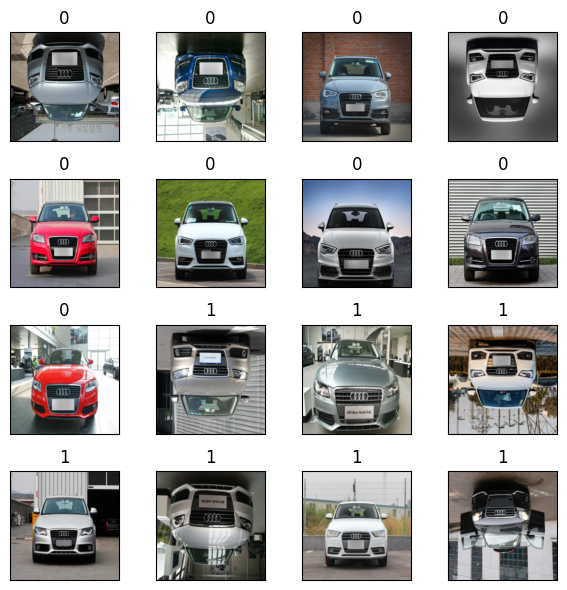

In [132]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"{train_dataset[i][1]}")
plt.tight_layout()

In [133]:
print(f'train dataset: {len(train_dataset)} \n test dataset: {len(test_dataset)} \n valid dataset: {len(valid_dataset)}')

train dataset: 2593 
 test dataset: 1196 
 valid dataset: 1185


In [143]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())

## 2. ResNet architecture

### 2.1 Identity block

The identity block corresponds to the case where the input activation ($a^{[l]}$) has the same dimension as the output activation ($a^{[l+2]}$).
In the case in which the skip connection "skips over" 3 hidden layers:

<img src="https://drive.google.com/uc?export=view&id=17ogAibvwczsmgQvXVvEbqg8aY4tAgdwr" style="width:800px;">

The upper path is the "shortcut path". The lower path is the "main path" with convolutional layers and ReLu activation functions. To speed up training we also add BatchNorm layers.  

Here are the individual steps:

**First component** of main path:
- CONV2D with $F_1$ filters of shape (1, 1), stride of (1, 1), padding "valid".
- BatchNorm, normalizing the 'channels' axis.
- ReLU activation function.

**Second component** of main path:
- CONV2D with $F_2$ filters of shape $(f, f)$, stride of (1, 1), padding "same".
- BatchNorm, normalizing the 'channels' axis.
- ReLU activation function.

**Third component** of main path:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (1, 1), padding "valid".
- BatchNorm, normalizing the 'channels' axis.

**Final step**:
- Add together the `X_input` and the output from the 3rd layer `X` (shortcut).
- ReLU activation function.

In [116]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU

class MainPath(Module):

    def __init__(self, in_channels, filters, kernel_size, stride=1):
        super().__init__()
        F1, F2, F3 = filters
        self.main_path = Sequential(
            Conv2d(in_channels, F1, kernel_size=1, stride=stride),
            BatchNorm2d(F1),
            ReLU(),
            Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2),
            BatchNorm2d(F2),
            ReLU(),
            Conv2d(F2, F3, kernel_size=1),
            BatchNorm2d(F3),
        )
        self.apply(self._init_weights) # initialize the weights of all layers

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

class IdentityBlock(MainPath): # inherits everything from MainPath

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size)
        self.relu = ReLU()

    def forward(self, x):
        y = self.relu(self.main_path(x) + x)
        return y

### 2.2 Convolutional block

You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:

<img src="https://drive.google.com/uc?export=view&id=1Lui0TVFvqyFleATruaKej37XgkzbpxlA" style="width:800px;">
<caption><center> Convolutional block </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path.  
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2.
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.

The details of the convolutional block are as follows:

**First component** of main path:
- CONV2D with $F_1$ filters of shape (1, 1), stride of (s, s), padding "valid".
- BatchNorm.
- ReLU activation function.

**Second component** of main path:
- CONV2D with $F_2$ filters of shape (f, f), stride of (1, 1), padding "same".
- BatchNorm.
- ReLU activation function.

**Third component** of main path:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (1,1), padding "valid".
- BatchNorm.
Note that there is no ReLU activation function in this component.

**Shortcut path**:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (s, s), padding "valid".
- BatchNorm.

**Final step**:
- Add together the shortcut and the main path values.
- ReLU activation function.

In [117]:
class ConvolutionalBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size, stride=2)
        self.relu = ReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, filters[2], kernel_size=1, stride=2),
            BatchNorm2d(filters[2])
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.relu(self.main_path(x) + self.shortcut_path(x))
        return y

### 2.3 ResNet model (50 layers)

The details of this ResNet-50 model are:
- Stage 1:
    - 2D Convolution with 64 filters of shape (7, 7) and stride of (2, 2).
    - BatchNorm, applied to the 'channels' axis of the input.
    - MaxPooling with (3, 3) window and (2, 2) stride.
- Stage 2:
    - Convolutional block with three sets of filters of size [64, 64, 256], `f = 3` and `s = 1`.
    - 2 identity blocks with three sets of filters of size [64,64,256], `f = 3`.
- Stage 3:
    - Convolutional block with three sets of filters of size [128, 128, 512], `f = 3` and `s = 2`.
    - 3 identity blocks with three sets of filters of size [128, 128, 512], `f = 3`.
- Stage 4:
    - Convolutional block with three sets of filters of size [256, 256, 1024], `f = 3` and `s = 2`.
    - 5 identity blocks with three sets of filters of size [256, 256, 1024], `f = 3`.
- Stage 5:
    - Convolutional block with three sets of filters of size [512, 512, 2048], `f = 3` and `s = 2`.
    - 2 identity blocks with three sets of filters of size [512, 512, 2048], `f = 3`.
- 2D Average Pooling with window of shape (2, 2).
- Flatten layer.
- Fully Connected (Dense) layer reduces its input to one single neuron at output using sigmoid activation.

In [137]:
from torch.nn import MaxPool2d, AvgPool2d, Linear, Dropout
class ResNet50(Module):

    def __init__(self):
        super().__init__()
        self.network = Sequential(
            Conv2d(3, 64, kernel_size=7, stride=2),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=3, stride=2),
            ConvolutionalBlock(64, [64, 64, 256], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            ConvolutionalBlock(256, [128, 128, 512], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            ConvolutionalBlock(512, [256, 256, 1024], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            ConvolutionalBlock(1024, [512, 512, 2048], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            AvgPool2d(kernel_size=2, stride=2)
        )
        self.classification_layer = Linear(8192, 431) ##AAAAAAAAAA
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x).reshape((x.shape[0], -1))
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

In [144]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from tqdm import tqdm
model = ResNet50()
opt = SGD(model.parameters(), lr=1e-2, weight_decay = 0)
loss_fn = CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs=10
best_val = np.inf
for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_pred = model(batch_x)

        loss = loss_fn(y_pred, batch_y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
    #print("qui")
    model.eval()
    #print("qua")
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)
            
            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
        print(f"loss: {val_loss}, accuracy: {val_acc}")

    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "model.pt")
        best_val = val_loss

Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  8.42it/s]


RuntimeError: The size of tensor a (431) must match the size of tensor b (1185) at non-singleton dimension 1